# NEURAL NETWORKS AND DEEP LEARNING
# HOMEWORK 2

**Giovanni Gazzola** <br>
**mtr:1227160**

## Libraries


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from numpy import linalg as la

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import plotly.express as px

In [ ]:
#set random seeds
torch.manual_seed(1227160)
np.random.seed(1227160)

## Dataset

In [ ]:
#downalod MNIST dataset
data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning:

The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)



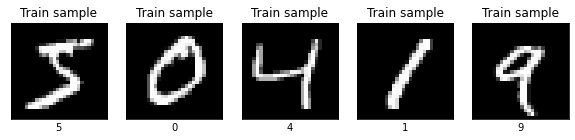

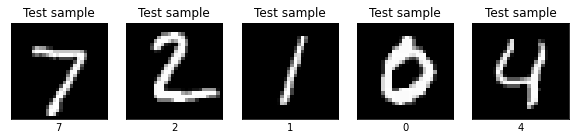

In [ ]:
#example of train and test images
plt.figure(figsize=(10,5))

for i in range(1, 6):
    plt.subplot(2,5,i)
    plt.xticks([])
    plt.yticks([])
    plt.title("Train sample")
    

    label = train_dataset.__getitem__(i-1)[1]
    plt.imshow(train_dataset.__getitem__(i-1)[0], cmap = 'gray')
    plt.xlabel(label)

plt.figure(figsize=(10,5))

for i in range(1, 6):
    plt.subplot(2,5,i)
    plt.xticks([])
    plt.yticks([])
    plt.title("Test sample")
    

    label = test_dataset.__getitem__(i-1)[1]
    plt.imshow(test_dataset.__getitem__(i-1)[0], cmap = 'gray')
    plt.xlabel(label)

## Transform

In [ ]:
#each time a sample is called we want to convert it from PIL image to tensor

train_transform = transforms.Compose([
        transforms.ToTensor(),            
])

test_transform = transforms.Compose([
         transforms.ToTensor(),                           
])

In [ ]:
#apply transformation to train dataset and test dataset
train_dataset.transform = train_transform
test_dataset.transform = test_transform

In [ ]:
#checking the shape and type of train and test samples
print('TRAIN:')
print(train_dataset[0][0].shape,'\n')

print('TEST:')
print(train_dataset[0][0].shape)

TRAIN:
torch.Size([1, 28, 28]) 

TEST:
torch.Size([1, 28, 28])


## Define Dataloader

In [ ]:
#define train dataloader enabling the shuffle of the data
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
#define test dataloader without shuffle the data
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

#check the right shape of the batches of both train and test dataloader
batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


## Convolutional Autoencoder

In this section we deifne the architecture of our convolutional autoencoder.

### Encoder

Defining the structure of our encoder

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        #convolutional part
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout(0.3),
            # Second convolutional layer
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout(0.3),
            # Third convolutional layer
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True),
        
        )
        
        #flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        #linear part
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(3 * 3 * 32, 64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(64, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        #print(x.shape)
        # Flatten
        x = self.flatten(x)
        #print(x.shape)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

### Decoder

Defining the structure of our decoder. In this case we create it as the inverse of the encoder.

In [ ]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()

        #linear part
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(64, 3 * 3 * 32),
            nn.ReLU(True)
        )

        #unflatten layer
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        #convolutional part
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        #print(x.shape)
        # Unflatten
        x = self.unflatten(x)
        #print(x.shape)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        #print(x.shape)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

Now we simply test that everything is like what we want. For example a latent space of dimension 2 is selected.

In [ ]:
#initialize two networks to visualize is the shapes are correct
encoded_space_dim = 2
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)

In [ ]:
# Take an input image 
img, _ = test_dataset[0]
img = img.unsqueeze(0) # add the batch dimension in the first axis
print('Original image shape:', img.shape)
# Encode the image
img_enc = encoder(img)
print('Encoded image shape:', img_enc.shape)
# Decode the image
dec_img = decoder(img_enc)
print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 2])
Decoded image shape: torch.Size([1, 1, 28, 28])


### Training of autoencoders with different latent space

Defining the training and testing funcion for unsupervised learning of our convolutional autoencoder.

In [ ]:
### Training function
def training_uns(enc, dec, train_dataloader):
    # Set train mode for both the encoder and the decoder
    enc.train()
    dec.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for sample_batched in train_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)

        # Encode data
        encoded_data = enc(x_batch)
        # Decode data
        decoded_data = dec(encoded_data)

        # Compute loss
        loss = loss_fn(decoded_data, x_batch)

        # Backpropagation
        optim.zero_grad()
        loss.backward()

        # Update the weights
        optim.step()

In [ ]:
### Testing function
def testing_uns(enc, dec, test_dataloader):
    # Set evaluation mode for encoder and decoder
    enc.eval()
    dec.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for sample_batched in test_dataloader:
            # Move data to device
            x_batch = sample_batched[0].to(device)

            # Encode data
            encoded_data = enc(x_batch)
            # Decode data
            decoded_data = dec(encoded_data)
    
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(x_batch.cpu())

        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In the following section of code we are training and testing diffrent convolutional autoencoders. Each of them differs from the dimension of the latent space.<br>
For each training iteration we are also plotting how the reconstruction of a random sample is performed.

In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

encoded_spaces = [1, 2, 3, 5, 10]
learning_rate = 1e-3 
last_loss = []
reconstructed_images = []

#test different latent spaces
for latent_space in encoded_spaces:
    encoder = Encoder(encoded_space_dim=latent_space)
    decoder = Decoder(encoded_space_dim=latent_space)

    ### Define the loss function
    loss_fn = torch.nn.MSELoss()

    ### Define an optimizer (both for the encoder and the decoder!)
    params_to_optimize = [
        {'params': encoder.parameters()},
        {'params': decoder.parameters()}
    ]
    optim = torch.optim.Adam(params_to_optimize, lr=learning_rate)

    # Move both the encoder and the decoder to the selected device
    encoder.to(device)
    decoder.to(device)

    #Training cycle
    num_epochs = 50
    for epoch in range(num_epochs):
        print('\nEpoch: ' , epoch + 1, ', Dimension of latent space = ', latent_space)
        #Training (use the training function)
        training_uns(encoder, decoder, train_dataloader)
        #Validation  (use the testing function)
        val_loss = testing_uns(encoder, decoder, test_dataloader)
        #Print validation loss of that epoch
        print('Validation loss: [',np.round(val_loss.item(),4), ']')

        
        #store some reconstructed images
        if epoch %10 == 0 or epoch == 49:
          img = test_dataset[1][0].unsqueeze(0).to(device)
          encoder.eval()
          decoder.eval()
          with torch.no_grad():
              rec_img  = decoder(encoder(img))
          
          reconstructed_images.append(rec_img.cpu().squeeze().numpy())

    #store the last validation loss for all the autoencoders
    last_loss.append(np.round(val_loss.item(),4))

    ### Get the encoded representation of the test samples for autoencoder whit latent space equal to 5
    if latent_space == 5:
      encoded_samples = []
      labels = []
      for sample in test_dataset:
          img = sample[0].unsqueeze(0).to(device)
          label = sample[1]
          # Encode image
          encoder.eval()
          with torch.no_grad():
              encoded_img  = encoder(img)
          # Append to list
          encoded_img = encoded_img.flatten().cpu().numpy()
          labels.append(label)
          encoded_samples.append(encoded_img)
      
      encoder_5 = encoder
      decoder_5 = decoder 
    

Selected device: cuda

Epoch:  1 , Dimension of latent space =  1
Validation loss: [ 0.0662 ]

Epoch:  2 , Dimension of latent space =  1
Validation loss: [ 0.0642 ]

Epoch:  3 , Dimension of latent space =  1
Validation loss: [ 0.0632 ]

Epoch:  4 , Dimension of latent space =  1
Validation loss: [ 0.0615 ]

Epoch:  5 , Dimension of latent space =  1
Validation loss: [ 0.0598 ]

Epoch:  6 , Dimension of latent space =  1
Validation loss: [ 0.059 ]

Epoch:  7 , Dimension of latent space =  1
Validation loss: [ 0.0588 ]

Epoch:  8 , Dimension of latent space =  1
Validation loss: [ 0.0581 ]

Epoch:  9 , Dimension of latent space =  1
Validation loss: [ 0.0577 ]

Epoch:  10 , Dimension of latent space =  1
Validation loss: [ 0.057 ]

Epoch:  11 , Dimension of latent space =  1
Validation loss: [ 0.0562 ]

Epoch:  12 , Dimension of latent space =  1
Validation loss: [ 0.0552 ]

Epoch:  13 , Dimension of latent space =  1
Validation loss: [ 0.0548 ]

Epoch:  14 , Dimension of latent space 

In [ ]:
#print the validation loss of each tested autoencoder
for i in range(0,len(last_loss)):
  print("Dimension of latent space: ", encoded_spaces[i], ', Validation loss: [', last_loss[i],']')


5
Dimension of latent space:  1 , Validation loss: [ 0.0484 ]
Dimension of latent space:  2 , Validation loss: [ 0.0389 ]
Dimension of latent space:  3 , Validation loss: [ 0.0324 ]
Dimension of latent space:  5 , Validation loss: [ 0.025 ]
Dimension of latent space:  10 , Validation loss: [ 0.015 ]


### Evaluation

In this section we are comparing the recunstruction of each convolutional auotoencoders. Moreover we are showing how the reconstruction has evolved during the training.


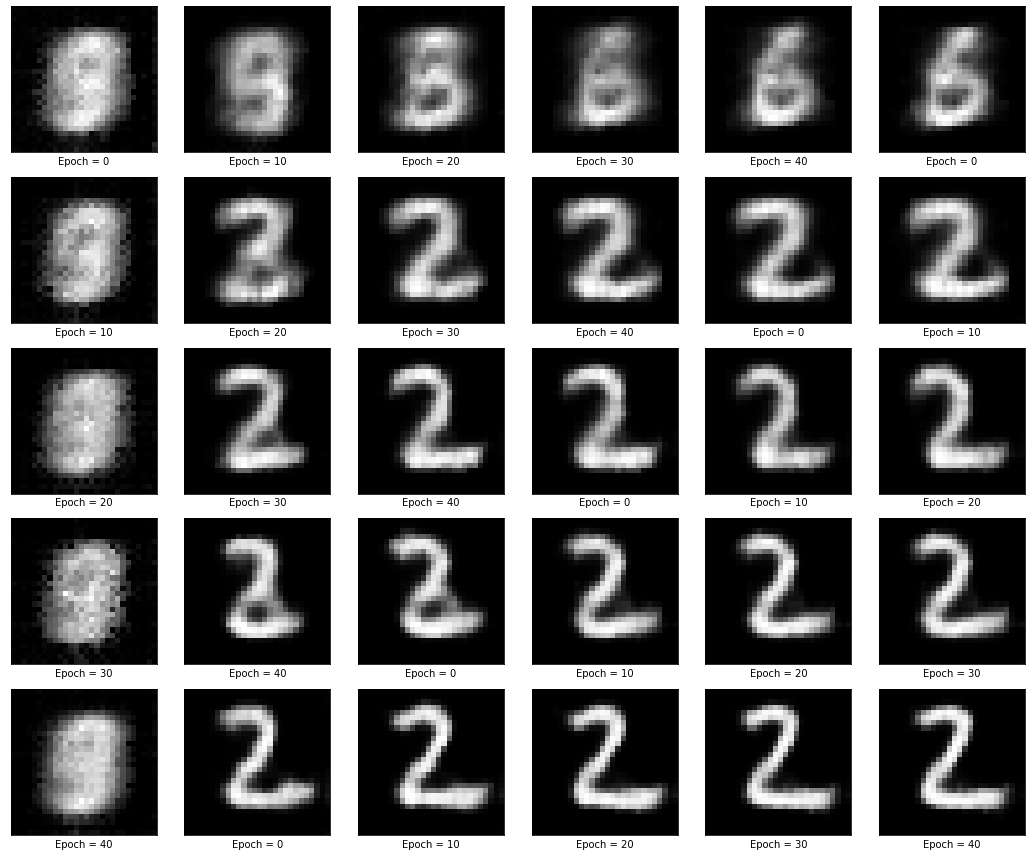

In [ ]:
#plot the evolution of reconstructed images for each autoencoder
plt.figure(figsize=(15,12))

#each row correspond to a latent space
for i in range(1, 31):
    plt.subplot(5,6,i)
    plt.xticks([])
    plt.yticks([])
    
    label = "Epoch = " + str(((i-1) % 5)*10)
    plt.imshow(reconstructed_images[i-1], cmap = 'gray')
    plt.xlabel(label)
    plt.tight_layout()


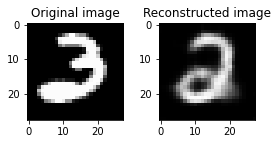

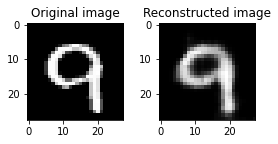

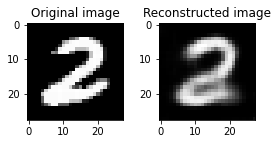

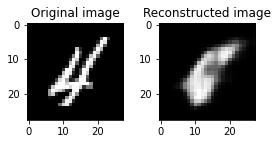

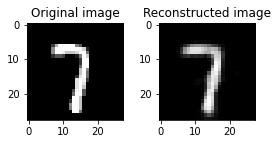

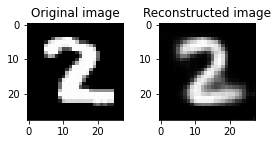

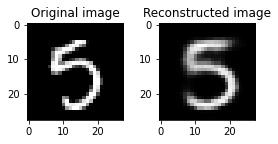

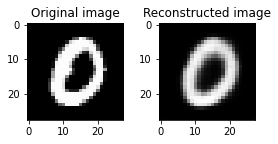

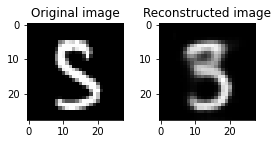

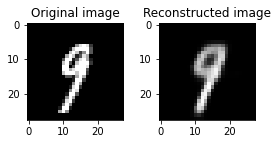

In [ ]:
#show some result on the test set of the autoencoder with latent space equal to 5
for i in np.random.randint(len(test_dataset)-1, size = 10):    
    img = test_dataset[i][0].unsqueeze(0).to(device, dtype=torch.float)
    encoder_5.eval()
    decoder_5.eval()
    with torch.no_grad():
        rec_img  = decoder_5(encoder_5(img))
    #Plot the reconstructed image
    fig, axs = plt.subplots(1, 2, figsize=(4,2))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap = 'gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap = 'gray')
    axs[1].set_title('Reconstructed image')
    plt.tight_layout()

## Latent space

In this section we are looking for understanding how the latent space is used by our encoder. <br>
First of all a PCA is performed over the encoded data to keep the most significant dimensions of the latent space.
After that the visualization of the encoded data is performed in a 2D plot. 

### PCA

In [ ]:
#defining PCA strategy that is used to reduce the dimensionality of the latent space to better visualize it
def PCA(array):
    
    avg = np.mean(array, axis = 1, keepdims=True)

    array = array - avg

    CX = np.cov(array)
    w,v = la.eig(CX)
    print(w) 
    print(v)

    CY =  np.diag(np.round(np.real(w),2))

    tr = 0;
    for i in range(0,5):
        tr = tr + CY[i,i]
        print("Fraction of the total variability keeping", i+1,"the first principal component: ", np.round(100*tr/CY.trace()),"%")

    P = v[:,0:2]
    #P = abs(P)

    array_final = P.T.dot(array)
        
    return array_final
    

In [ ]:
#prepare everithing to performed a PCA
array = np.array(encoded_samples)
matrix = array.T
matrix.shape

(5, 10000)

In [ ]:
#apply PCA and keep just hte two most significant directions 
latent_PCA = PCA(matrix)

[96.44854172 49.80332175 26.54137024 21.82260253 18.15275875]
[[-0.59837541  0.37366895  0.60949451 -0.31958263 -0.16941597]
 [ 0.29344697 -0.39516877  0.05854119 -0.53869408 -0.68125776]
 [ 0.08044501  0.62686867 -0.56993482 -0.52385302  0.03628477]
 [ 0.24434769 -0.24795652  0.30366865 -0.54089077  0.70287573]
 [-0.69975607 -0.49976635 -0.45612391 -0.20171963  0.10878978]]
Fraction of the total variability keeping 1 the first principal component:  45.0 %
Fraction of the total variability keeping 2 the first principal component:  69.0 %
Fraction of the total variability keeping 3 the first principal component:  81.0 %
Fraction of the total variability keeping 4 the first principal component:  91.0 %
Fraction of the total variability keeping 5 the first principal component:  100.0 %


###Visualization 

In [ ]:
#building a DataFrame with the encoded data
latent_PCA.T.shape

latent_PCA = pd.DataFrame(latent_PCA.T)
latent_PCA.columns = ['Enc. Variable 0', 'Enc. Variable 1']
# Using DataFrame.insert() to add a column 
latent_PCA.insert(2, "label", labels, True) 

latent_PCA.head()

,Enc. Variable 0,Enc. Variable 1,label
0,20.196853,-9.439767,7
1,-5.833814,8.483890,2
2,26.879801,19.201025,1
3,-11.560665,-1.962869,0
4,4.599802,-16.592534,4


In [ ]:
#plotting encoded data after applying PCA and color them according to thir label
px.scatter(latent_PCA, x='Enc. Variable 0', y='Enc. Variable 1', color=latent_PCA.label.astype(str), opacity=0.7)

Now we try to use the information that we have about how classes are distributed over the latent space to recreat some specific samples starting from the coordinates of the latent space.

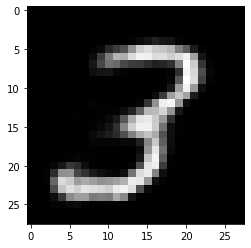

In [ ]:
# Generate a custom sample
custom_encoded_sample = [0, 0, 0, -10,-10]
encoded_value = torch.tensor(custom_encoded_sample).float().unsqueeze(0).to(device)

# Decode sample
decoder_5.eval()
with torch.no_grad():
    generated_img  = decoder_5(encoded_value)

plt.figure(figsize=(8,4))
plt.imshow(generated_img.squeeze().cpu().numpy(), cmap='gray')
plt.show()

## Supervised training for the encoder

In this Section we provide a supervised training to our encoder, which will be able to classy mostly of the input sample after represents them in the latent space.<br>
After that we are using the pre-trained encoder to train the decoder on reconstructing the original samples.<br>
At the end the visualization of the latent space is performed.

### Supervised train

In [ ]:
# splliting the trainig dataset into train and validation 
alpha = 0.2
split = int(len(train_dataset) * 0.2)

tr_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [len(train_dataset)-split, split])

print('Samples in training set:',len(tr_dataset))
print('Samples in validation set:',len(val_dataset))

Samples in training set: 48000
Samples in validation set: 12000


In [ ]:
#apply transformation to train dataset and test dataset
tr_dataset.transform = train_transform
val_dataset.transform = train_transform

#define train dataloader enabling the shuffle of the data
train_dataloader_sup = DataLoader(tr_dataset, batch_size=256, shuffle=True)
#define test dataloader without shuffle the data
val_dataloader_sup = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)


Adding a Linear layer at the output of the encoder to train it in a supervised way

In [ ]:
latent_space = 5
#initialize the encoder 
encoder_sup = Encoder(encoded_space_dim=latent_space)

class_layer = nn.Linear(latent_space,10)

print(encoder_sup)
print(class_layer)

Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (7): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=5, bias=True)
  )
)
Linear(in_features=5, out_features=10, bias=True)


In [ ]:
def training_sup(enc, layer, train_dataloader_sup):
  enc.train()
  layer.train()
  for sample_batched in train_dataloader_sup:
      # Move data to device
      x_batch = sample_batched[0].to(device)
      label_batch = sample_batched[1].to(device)

      # Forward pass
      x = enc(x_batch)
      out = layer(x)
      
      # Compute loss
      loss = loss_sup(out, label_batch)

      # Backpropagation
      enc.zero_grad()
      layer.zero_grad()
      loss.backward()

      # Update the weights
      optimizer_sup.step()

      # Save train loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      train_loss.append(loss_batch)

      #get the accuracy for this batch
      pred = np.argmax(out.detach().cpu().numpy(), axis = 1)
      right = np.sum(pred == np.array(label_batch.cpu()))
      acc_t.append(right)



In [ ]:
def validation_sup(enc, layer, val_dataloader_sup):
  enc.eval()
  layer.eval()
  with torch.no_grad(): # Disable gradient tracking
    for sample_batched in val_dataloader_sup:
      # Move data to device
      x_batch = sample_batched[0].to(device)
      label_batch = sample_batched[1].to(device)

      # Forward pass
      x = enc(x_batch)
      out = layer(x)

      # Compute loss
      loss = loss_sup(out, label_batch)

      # Save val loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      val_loss.append(loss_batch)

      #get the accuracy for the val
      pred = np.argmax(out.detach().cpu().numpy(), axis = 1)
      right = np.sum(pred == np.array(label_batch.cpu()))
      acc_v.append(right)

In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

#moving both the encoder and the layer for classification to GPU
encoder_sup.to(device)
class_layer.to(device)

# Define the loss function
loss_sup = nn.CrossEntropyLoss()

#optimize the parameters of both the encoder and the layer fot classification
params_to_optimize = [
        {'params': encoder_sup.parameters()},
        {'params': class_layer.parameters()}
    ]

optimizer_sup = torch.optim.Adam(params_to_optimize, lr=1e-3)


Training device: cuda


In [ ]:
 ### TRAINING LOOP
num_epochs = 20
acc_train = 0
acc_val = 0
train_loss_log = []
val_loss_log = []
for epoch_num in range(num_epochs):
    ### TRAIN
    acc_t = []
    acc_v = []
    train_loss= []
    # Training mode 
    training_sup(encoder_sup, class_layer, train_dataloader_sup)

    # Save average train loss
    train_loss = np.mean(train_loss)
    train_loss_log.append(train_loss)

    ### VALIDATION
    val_loss= []
    # Evaluation mode (e.g. disable dropout)
    validation_sup(encoder_sup, class_layer, val_dataloader_sup)

    # Save average validation loss
    val_loss = np.mean(val_loss)
    val_loss_log.append(val_loss)

    acc_train = np.sum(acc_t)/len(tr_dataset)
    acc_val = np.sum(acc_v)/len(val_dataset)
    print("Epoch", epoch_num + 1, "= Average train loss:[", train_loss, "] ","Accuracy train:[", np.round(acc_train,5),"] " ,"Average validation loss: [", val_loss, "]", "Accuracy validation:[",  np.round(acc_val,5),"]")
print("\n")

Epoch 1 = Average train loss:[ 1.5212954 ]  Accuracy train:[ 0.46765 ]  Average validation loss: [ 0.6937887 ] Accuracy validation:[ 0.79925 ]
Epoch 2 = Average train loss:[ 0.6059528 ]  Accuracy train:[ 0.81302 ]  Average validation loss: [ 0.3631084 ] Accuracy validation:[ 0.89442 ]
Epoch 3 = Average train loss:[ 0.39992994 ]  Accuracy train:[ 0.88083 ]  Average validation loss: [ 0.24631289 ] Accuracy validation:[ 0.93142 ]
Epoch 4 = Average train loss:[ 0.3015994 ]  Accuracy train:[ 0.91129 ]  Average validation loss: [ 0.20111763 ] Accuracy validation:[ 0.94292 ]
Epoch 5 = Average train loss:[ 0.25189403 ]  Accuracy train:[ 0.92529 ]  Average validation loss: [ 0.15728132 ] Accuracy validation:[ 0.95417 ]
Epoch 6 = Average train loss:[ 0.21510534 ]  Accuracy train:[ 0.93604 ]  Average validation loss: [ 0.1333076 ] Accuracy validation:[ 0.96258 ]
Epoch 7 = Average train loss:[ 0.1885835 ]  Accuracy train:[ 0.94477 ]  Average validation loss: [ 0.11827681 ] Accuracy validation:[ 0.

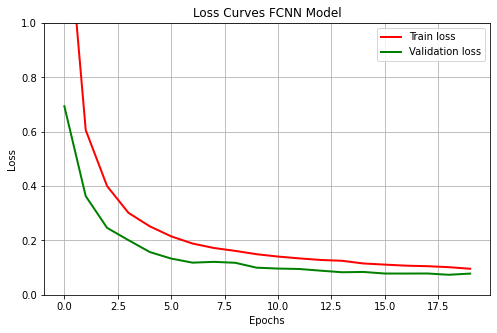

In [ ]:
# Plot losses
plt.figure(figsize=(8,5))
plt.plot(train_loss_log, linewidth = 2.0,  label = "Train loss", color="red")
plt.plot(val_loss_log,linewidth = 2.0, label = "Validation loss", color = "green")
plt.legend(loc="upper right")
plt.title('Loss Curves FCNN Model')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0,1])
plt.show()

In [ ]:
#show the metrics reached by the models
print('MODEL')
print("  Final train loss:[", train_loss_log[len(train_loss_log)-1], "] ","Final validation loss: [", val_loss_log[len(val_loss_log)-1], "]")
print("  Final train accuracy:[", np.round(acc_train,5), "] ","Final validation accuracy: [", np.round(acc_val,5), "]")
print('\n')

MODEL
  Final train loss:[ 0.09577678 ]  Final validation loss: [ 0.07804213 ]
  Final train accuracy:[ 0.97067 ]  Final validation accuracy: [ 0.97817 ]




### Evaluation of the encoder

In [ ]:
test_loss = []
acc = 0
#move the input to the GPU and predict the output
encoder_sup.eval()
class_layer.eval()
with torch.no_grad(): # No need to track the gradients
  # Define the lists to store the outputs for each batch
  conc_out = []
  conc_label = []
  for sample_batched in test_dataloader:
      # Move data to device
      x_batch = sample_batched[0].to(device)
      y = sample_batched[1].to(device)
      # Encode data
      x = encoder_sup(x_batch)
      out = class_layer(x)
      
      # Append the network output and the original image to the lists
      loss = loss_sup(out, y)
      test_loss.append(loss.detach().cpu().numpy())

      pred = np.argmax(out.detach().cpu().numpy(), axis = 1)
      right = np.sum(pred == np.array(y.cpu()))
      acc = acc + right

  # Evaluate global loss
  test_loss = np.mean(test_loss)

print("Test loss MODEL:[", float(test_loss),"]", " Accuracy of MODEL:[", np.round(acc/len(test_dataset),5),"]")

Test loss MODEL:[ 0.05954872444272041 ]  Accuracy of MODEL:[ 0.981 ]


### Training of the autoencoder with the pretrained encoder

In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

encoded_spaces = 5
learning_rate = 1e-3 
last_loss = []
reconstructed_images = []

decoder = Decoder(encoded_space_dim=latent_space)

### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (just for the decoder!)

optim = torch.optim.Adam(decoder.parameters(), lr=learning_rate)

# Move the decoder to the selected device
decoder.to(device)

#Training cycle
num_epochs = 50
for epoch in range(num_epochs):
    print('\nEpoch: ' , epoch + 1, ', Dimension of latent space = ', latent_space)
    #Training (use the training function)
    training_uns(encoder_sup, decoder)
    #Validation  (use the testing function)
    val_loss = testing_uns(encoder_sup, decoder)
    #Print validation loss of that epoch
    print('Validation loss: [',np.round(val_loss.item(),4), ']')

#store the last validation loss for all the autoencoders
last_loss.append(np.round(val_loss.item(),4))

encoded_samples = []
labels = []
for sample in test_dataset:
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder_sup.eval()
    with torch.no_grad():
        encoded_img  = encoder_sup(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    labels.append(label)
    encoded_samples.append(encoded_img)

Selected device: cuda

Epoch:  1 , Dimension of latent space =  5
Validation loss: [ 0.0564 ]

Epoch:  2 , Dimension of latent space =  5
Validation loss: [ 0.0497 ]

Epoch:  3 , Dimension of latent space =  5
Validation loss: [ 0.0466 ]

Epoch:  4 , Dimension of latent space =  5
Validation loss: [ 0.045 ]

Epoch:  5 , Dimension of latent space =  5
Validation loss: [ 0.0445 ]

Epoch:  6 , Dimension of latent space =  5
Validation loss: [ 0.044 ]

Epoch:  7 , Dimension of latent space =  5
Validation loss: [ 0.0436 ]

Epoch:  8 , Dimension of latent space =  5
Validation loss: [ 0.0434 ]

Epoch:  9 , Dimension of latent space =  5
Validation loss: [ 0.0432 ]

Epoch:  10 , Dimension of latent space =  5
Validation loss: [ 0.0431 ]

Epoch:  11 , Dimension of latent space =  5
Validation loss: [ 0.0427 ]

Epoch:  12 , Dimension of latent space =  5
Validation loss: [ 0.0429 ]

Epoch:  13 , Dimension of latent space =  5
Validation loss: [ 0.0427 ]

Epoch:  14 , Dimension of latent space 

In [ ]:
#print the validation loss of each tested autoencoder
print("Dimension of latent space: ", encoded_spaces, ', Validation loss: [', last_loss[0],']')

Dimension of latent space:  5 , Validation loss: [ 0.0416 ]


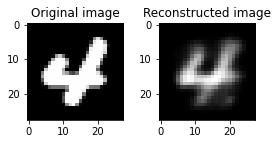

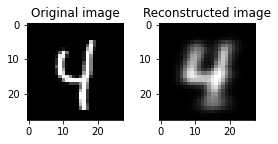

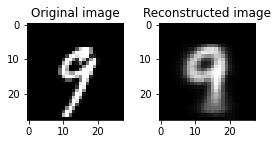

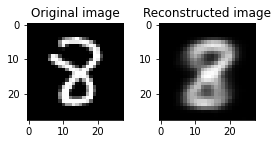

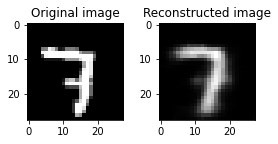

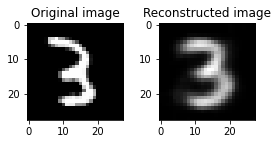

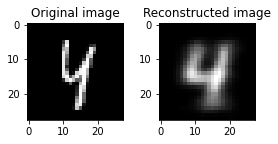

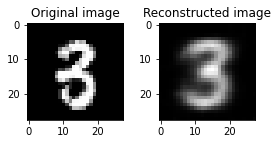

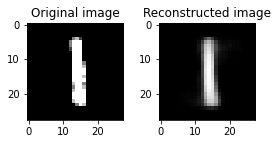

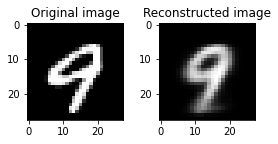

In [ ]:
#show some result on the test set of the autoencoder 
for i in np.random.randint(len(test_dataset)-1, size = 10):    
    img = test_dataset[i][0].unsqueeze(0).to(device, dtype=torch.float)
    encoder_sup.eval()
    decoder.eval()
    with torch.no_grad():
        rec_img  = decoder(encoder_sup(img))
    #Plot the reconstructed image
    fig, axs = plt.subplots(1, 2, figsize=(4,2))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap = 'gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap = 'gray')
    axs[1].set_title('Reconstructed image')
    plt.tight_layout()

### Visualization

In [ ]:
array = np.array(encoded_samples)
matrix = array.T
matrix.shape

latent_PCA = PCA(matrix)

[190.68704414 159.79593179 144.42899075  35.374253    60.26728867]
[[ 0.14637842  0.71434579 -0.66067289  0.14827648 -0.09903975]
 [-0.11755183  0.67428269  0.59974349 -0.40674059  0.07996405]
 [ 0.5946377   0.1228208   0.43573546  0.63733025 -0.18779198]
 [ 0.20515811 -0.09514146 -0.01959193 -0.41876523 -0.87926679]
 [ 0.754368   -0.10448015 -0.11648968 -0.48064749  0.41883286]]
Fraction of the total variability keeping 1 the first principal component:  32.0 %
Fraction of the total variability keeping 2 the first principal component:  59.0 %
Fraction of the total variability keeping 3 the first principal component:  84.0 %
Fraction of the total variability keeping 4 the first principal component:  90.0 %
Fraction of the total variability keeping 5 the first principal component:  100.0 %


In [ ]:
latent_PCA.T.shape

latent_PCA = pd.DataFrame(latent_PCA.T)
latent_PCA.columns = ['Enc. Variable 0', 'Enc. Variable 1']
# Using DataFrame.insert() to add a column 
latent_PCA.insert(2, "label", labels, True) 

In [ ]:
px.scatter(latent_PCA, x='Enc. Variable 0', y='Enc. Variable 1', color=latent_PCA.label.astype(str), opacity=0.7)

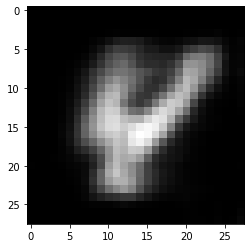

In [ ]:
# Generate a custom sample
custom_encoded_sample = [8, 5, 5, 5, 5]
encoded_value = torch.tensor(custom_encoded_sample).float().unsqueeze(0).to(device)

# Decode sample
decoder.eval()
with torch.no_grad():
    generated_img  = decoder(encoded_value)

plt.figure(figsize=(8,4))
plt.imshow(generated_img.squeeze().cpu().numpy(), cmap='gray')
plt.show()

## Semi-Supervised training for the encoder

In this section the encoder is firstly trained in an unsupervised way (90% of the training set). Then it's trained in a supervised way (10% of the training set). <br>
To conclude the convolutional autoencoder with the encoder trained in a semi-supervised way is tested.

### Unsupervised train

In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

encoded_spaces = 5
learning_rate = 1e-3 
last_loss = []

encoder = Encoder(encoded_space_dim=encoded_spaces)
decoder = Decoder(encoded_space_dim=encoded_spaces)

### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=learning_rate)

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

#Training cycle
num_epochs = 50
for epoch in range(num_epochs):
    print('\nEpoch: ' , epoch + 1, ', Dimension of latent space = ', encoded_spaces)
    #Training (use the training function)
    training_uns(encoder, decoder, train_dataloader_sup)
    #Validation  (use the testing function)
    val_loss = testing_uns(encoder, decoder, test_dataloader)
    #Print validation loss of that epoch
    print('Validation loss: [',np.round(val_loss.item(),4), ']')

#store the last validation loss for all the autoencoders
last_loss.append(np.round(val_loss.item(),4))

Selected device: cuda

Epoch:  1 , Dimension of latent space =  5
Validation loss: [ 0.0658 ]

Epoch:  2 , Dimension of latent space =  5
Validation loss: [ 0.0526 ]

Epoch:  3 , Dimension of latent space =  5
Validation loss: [ 0.0444 ]

Epoch:  4 , Dimension of latent space =  5
Validation loss: [ 0.0375 ]

Epoch:  5 , Dimension of latent space =  5
Validation loss: [ 0.0348 ]

Epoch:  6 , Dimension of latent space =  5
Validation loss: [ 0.033 ]

Epoch:  7 , Dimension of latent space =  5
Validation loss: [ 0.0319 ]

Epoch:  8 , Dimension of latent space =  5
Validation loss: [ 0.0311 ]

Epoch:  9 , Dimension of latent space =  5
Validation loss: [ 0.0305 ]

Epoch:  10 , Dimension of latent space =  5
Validation loss: [ 0.0299 ]

Epoch:  11 , Dimension of latent space =  5
Validation loss: [ 0.0294 ]

Epoch:  12 , Dimension of latent space =  5
Validation loss: [ 0.0291 ]

Epoch:  13 , Dimension of latent space =  5
Validation loss: [ 0.0289 ]

Epoch:  14 , Dimension of latent space

In [ ]:
#print the validation loss of tested autoencoder
print("Dimension of latent space: ", encoded_spaces, ', Validation loss: [', last_loss[0],']')

Dimension of latent space:  5 , Validation loss: [ 0.0246 ]


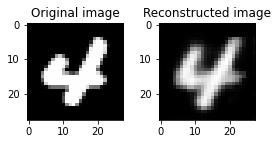

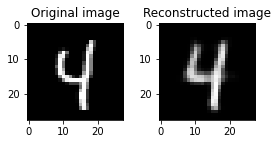

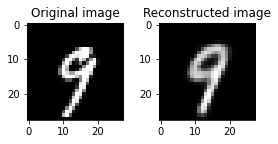

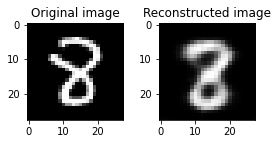

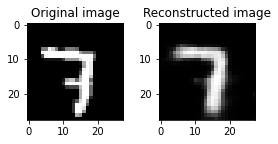

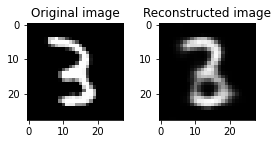

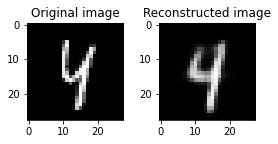

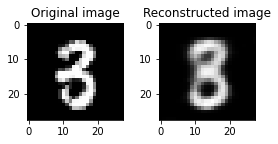

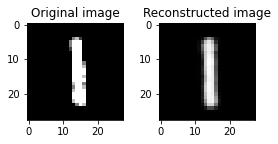

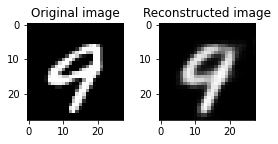

In [ ]:
#show some result on the test set of the autoencoder 
for i in np.random.randint(len(test_dataset)-1, size = 10):    
    img = test_dataset[i][0].unsqueeze(0).to(device, dtype=torch.float)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        rec_img  = decoder(encoder(img))
    #Plot the reconstructed image
    fig, axs = plt.subplots(1, 2, figsize=(4,2))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap = 'gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap = 'gray')
    axs[1].set_title('Reconstructed image')
    plt.tight_layout()

### Supervised train

In [ ]:
#create an output layer for the encoder to perform classification
latent_space = 5
class_layer = nn.Linear(latent_space,10)

# Disallow the update of all the layers by setting the 'requires_grad' parameter of the tensors to 'False'
for param_name, param in encoder.named_parameters():
    param.requires_grad = False

# Allow the training of the last layers (classifier[4] and classifier[6])
for param in encoder.encoder_lin[2].parameters():
    param.requires_grad = True

for param in encoder.encoder_lin[0].parameters():
    param.requires_grad = True

# Check if correct
for param_name, param in encoder.named_parameters():
    print('%s \t- requires_grad=%s' % (param_name, param.requires_grad))
 
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

#moving both the encoder and the layer for classification to GPU
class_layer.to(device)

# Define the loss function
loss_sup = nn.CrossEntropyLoss()

#optimize the parameters of both the encoder and the layer fot classification
params_to_optimize = [
        {'params': encoder.parameters()},
        {'params': class_layer.parameters()}
    ]

optimizer_sup = torch.optim.Adam(params_to_optimize, lr=1e-3)


encoder_cnn.0.weight 	- requires_grad=False
encoder_cnn.0.bias 	- requires_grad=False
encoder_cnn.3.weight 	- requires_grad=False
encoder_cnn.3.bias 	- requires_grad=False
encoder_cnn.6.weight 	- requires_grad=False
encoder_cnn.6.bias 	- requires_grad=False
encoder_lin.0.weight 	- requires_grad=True
encoder_lin.0.bias 	- requires_grad=True
encoder_lin.2.weight 	- requires_grad=True
encoder_lin.2.bias 	- requires_grad=True
Training device: cuda


In [ ]:
 ### TRAINING LOOP
num_epochs = 20
acc_train = 0
acc_val = 0
train_loss_log = []
val_loss_log = []
for epoch_num in range(num_epochs):
    ### TRAIN
    acc_t = []
    acc_v = []
    train_loss= []
    # Training mode 
    training_sup(encoder, class_layer, train_dataloader_sup)

    # Save average train loss
    train_loss = np.mean(train_loss)
    train_loss_log.append(train_loss)

    ### VALIDATION
    val_loss= []
    # Evaluation mode (e.g. disable dropout)
    validation_sup(encoder, class_layer, val_dataloader_sup)

    # Save average validation loss
    val_loss = np.mean(val_loss)
    val_loss_log.append(val_loss)

    acc_train = np.sum(acc_t)/len(tr_dataset)
    acc_val = np.sum(acc_v)/len(val_dataset)
    print("Epoch", epoch_num + 1, "= Average train loss:[", train_loss, "] ","Accuracy train:[", np.round(acc_train,5),"] " ,"Average validation loss: [", val_loss, "]", "Accuracy validation:[",  np.round(acc_val,5),"]")
print("\n")

Epoch 1 = Average train loss:[ 1.5059613 ]  Accuracy train:[ 0.54175 ]  Average validation loss: [ 0.6813667 ] Accuracy validation:[ 0.80725 ]
Epoch 2 = Average train loss:[ 0.5486177 ]  Accuracy train:[ 0.84196 ]  Average validation loss: [ 0.38398612 ] Accuracy validation:[ 0.89792 ]
Epoch 3 = Average train loss:[ 0.38760343 ]  Accuracy train:[ 0.88654 ]  Average validation loss: [ 0.29571947 ] Accuracy validation:[ 0.91975 ]
Epoch 4 = Average train loss:[ 0.32154214 ]  Accuracy train:[ 0.90558 ]  Average validation loss: [ 0.24273401 ] Accuracy validation:[ 0.93358 ]
Epoch 5 = Average train loss:[ 0.28610295 ]  Accuracy train:[ 0.91504 ]  Average validation loss: [ 0.21713965 ] Accuracy validation:[ 0.938 ]
Epoch 6 = Average train loss:[ 0.2625455 ]  Accuracy train:[ 0.91977 ]  Average validation loss: [ 0.19450997 ] Accuracy validation:[ 0.94633 ]
Epoch 7 = Average train loss:[ 0.24399534 ]  Accuracy train:[ 0.92502 ]  Average validation loss: [ 0.1790463 ] Accuracy validation:[ 0.

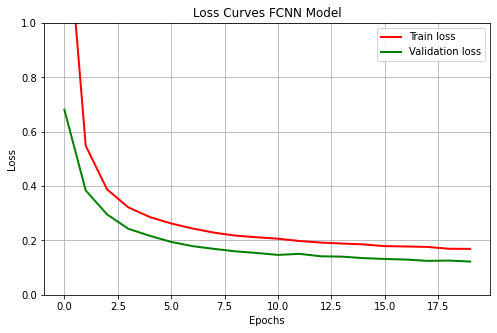

In [ ]:
# Plot losses
plt.figure(figsize=(8,5))
plt.plot(train_loss_log, linewidth = 2.0,  label = "Train loss", color="red")
plt.plot(val_loss_log,linewidth = 2.0, label = "Validation loss", color = "green")
plt.legend(loc="upper right")
plt.title('Loss Curves FCNN Model')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0,1])
plt.show()

In [ ]:
#show the metrics reached by the models
print('MODEL')
print("  Final train loss:[", train_loss_log[len(train_loss_log)-1], "] ","Final validation loss: [", val_loss_log[len(val_loss_log)-1], "]")
print("  Final train accuracy:[", np.round(acc_train,5), "] ","Final validation accuracy: [", np.round(acc_val,5), "]")
print('\n')

MODEL
  Final train loss:[ 0.16893385 ]  Final validation loss: [ 0.122283936 ]
  Final train accuracy:[ 0.94652 ]  Final validation accuracy: [ 0.96392 ]




In [ ]:
test_loss = []
acc = 0
#move the input to the GPU and predict the output
encoder.eval()
class_layer.eval()
with torch.no_grad(): # No need to track the gradients
  # Define the lists to store the outputs for each batch
  conc_out = []
  conc_label = []
  for sample_batched in test_dataloader:
      # Move data to device
      x_batch = sample_batched[0].to(device)
      y = sample_batched[1].to(device)
      # Encode data
      x = encoder(x_batch)
      out = class_layer(x)
      
      # Append the network output and the original image to the lists
      loss = loss_sup(out, y)
      test_loss.append(loss.detach().cpu().numpy())

      pred = np.argmax(out.detach().cpu().numpy(), axis = 1)
      right = np.sum(pred == np.array(y.cpu()))
      acc = acc + right

  # Evaluate global loss
  test_loss = np.mean(test_loss)

print("Test loss MODEL:[", float(test_loss),"]", " Accuracy of MODEL:[", np.round(acc/len(test_dataset),5),"]")

Test loss MODEL:[ 0.11575533449649811 ]  Accuracy of MODEL:[ 0.9621 ]


## Denoising convolutional autoencoder

In this section a denoising convolutional autoencoder is built. <br>
The auotencoder needs to reconstruct images without noise after that an noisy input has been used.

### Adding noise

In [ ]:
train_dataset_noise = []
test_dataset_noise = []

mean = 0
std = 0.5
for image in train_dataset:
  train_dataset_noise.append(image[0][0] + np.random.normal(mean, std, train_dataset[0][0].shape))

for image in test_dataset:
  test_dataset_noise.append(image[0][0] + np.random.normal(mean, std, test_dataset[0][0].shape))

In [ ]:
#Plot the noise images
fig, axs = plt.subplots(1, 2, figsize=(6,3))
axs[0].imshow(train_dataset[0][0].squeeze(0), cmap = 'gray')
axs[0].set_title('Original image')
axs[1].imshow(train_dataset_noise[0].squeeze(0), cmap = 'gray')
axs[1].set_title('Noisy image')
plt.tight_layout()
plt.suptitle('Train sample')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(6,3))
axs[0].imshow(test_dataset[0][0].squeeze(0), cmap = 'gray')
axs[0].set_title('Original image')
axs[1].imshow(test_dataset_noise[0].squeeze(0), cmap = 'gray')
axs[1].set_title('Noisy image')
plt.tight_layout()
plt.suptitle('Test sample')
plt.show()

### Training phase

In [ ]:

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)
#define train noisy dataloader enabling the shuffle of the data
train_dataloader_noise = DataLoader(train_dataset_noise, batch_size=256, shuffle=False)
#define test noisy dataloader without shuffle the data
test_dataloader_noise = DataLoader(test_dataset_noise, batch_size=256, shuffle=False)

In [ ]:
### Training function
def training_uns_noise(enc, dec):
    # Set train mode for both the encoder and the decoder
    enc.train()
    dec.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for sample_batched_noise, sample_batched in zip(train_dataloader_noise, train_dataloader):
        # Move data to device
        x_batch_noise = sample_batched_noise.to(device,  dtype=torch.float)
        x_batch = sample_batched[0].to(device)

        # Encode data
        encoded_data = enc(x_batch_noise)
        # Decode data
        decoded_data = dec(encoded_data)

        # Compute loss
        loss = loss_fn(decoded_data, x_batch)

        # Backpropagation
        optim.zero_grad()
        loss.backward()

        # Update the weights
        optim.step()

In [ ]:
### Testing function
def testing_uns_noise(enc, dec):
    # Set evaluation mode for encoder and decoder
    enc.eval()
    dec.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for sample_batched, sample_batched_noise in zip(test_dataloader, test_dataloader_noise):
            # Move data to device
            x_batch_noise = sample_batched_noise.to(device,  dtype=torch.float)
            x_batch = sample_batched[0].to(device)

            # Encode data
            encoded_data = enc(x_batch_noise)
            # Decode data
            decoded_data = dec(encoded_data)
            
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(x_batch.cpu())

        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

encoded_spaces = 5
learning_rate = 1e-3 
last_loss = []

encoder = Encoder(encoded_space_dim=encoded_spaces)
decoder = Decoder(encoded_space_dim=encoded_spaces)

### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=learning_rate)

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

#Training cycle
num_epochs = 50
for epoch in range(num_epochs):
    print('\nEpoch: ' , epoch + 1, ', Dimension of latent space = ', encoded_spaces)
    #Training (use the training function)
    training_uns_noise(encoder, decoder)
    #Validation  (use the testing function)
    val_loss = testing_uns_noise(encoder, decoder)
    #Print validation loss of that epoch
    print('Validation loss: [',np.round(val_loss.item(),4), ']')

#store the last validation loss for all the autoencoders
last_loss.append(np.round(val_loss.item(),4))

### Evaluation

In [ ]:
#show some result on the test set of the denoising autoencoder 
for i in np.random.randint(len(test_dataset_noise)-1, size = 10):    
    img = test_dataset_noise[i].unsqueeze(0).to(device, dtype=torch.float)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        rec_img  = decoder(encoder(img))
    #Plot the reconstructed image
    fig, axs = plt.subplots(1, 3, figsize=(6,3))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap = 'gray')
    axs[0].set_title('Original noisy image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap = 'gray')
    axs[1].set_title('Reconstructed image')
    axs[2].imshow(test_dataset[i][0].squeeze(0), cmap = 'gray')
    axs[2].set_title('Original image')
    plt.tight_layout()
    

## Generative Adversarial Network 

In this section a GAN is implemented. The procedure involved two different neural networks, one that acts as descriminator and on that acts as generator. <br>
The goal is to obtained a generator that is able to create inputs such that the descriminator is not able to classify them as fake (not from the original set).